In [1]:
import os
import cv2
import time
import pandas as pd
import numpy as np

from PIL import Image

import torch
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import glob

In [3]:
image_df= pd.read_csv('Train.csv')

In [4]:
image_df.head()

,Image_ID,x,y,w,h
0,04FB1B33,0.481988,0.506076,0.174696,0.405671
1,B04E481E,0.617405,0.313368,0.177734,0.293113
2,32655645,0.490885,0.465856,0.165582,0.357350
3,44D4DA7C,0.472873,0.506076,0.237847,0.409722
4,4F36EF72,0.433811,0.574363,0.180773,0.397569


In [5]:
image_df = image_df.head(700)

In [6]:
image_df.rename(columns={'Image_ID':'filename'},inplace=True)

In [7]:
image_df.head()

,filename,x,y,w,h
0,04FB1B33,0.481988,0.506076,0.174696,0.405671
1,B04E481E,0.617405,0.313368,0.177734,0.293113
2,32655645,0.490885,0.465856,0.165582,0.357350
3,44D4DA7C,0.472873,0.506076,0.237847,0.409722
4,4F36EF72,0.433811,0.574363,0.180773,0.397569


This dataset contains single class

In [8]:
image_df['class'] = '1'

In [9]:
DIR_IMAGES = 'IMAGES_1024'

In [10]:
for idx, row in image_df.iterrows():
    bbox = image_df[image_df['filename'] == row['filename']]
    img_path = os.path.join(DIR_IMAGES, row['filename']+'.jpg')
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_df.loc[(image_df['filename'] == row['filename']),'x'] = int(bbox['x']*image.shape[1])
    image_df.loc[(image_df['filename'] == row['filename']),'y'] = int(bbox['y']*image.shape[0])
    image_df.loc[(image_df['filename'] == row['filename']),'w'] = int((bbox['x']+bbox['w'])*image.shape[1])
    image_df.loc[(image_df['filename'] == row['filename']),'h'] = int((bbox['y']+bbox['h'])*image.shape[0])
    

In [11]:
def plot_img(image_name,df):
    fig, ax = plt.subplots(1, 2, figsize = (14, 14))
    ax = ax.flatten()   
    bbox = df[df['filename'] == image_name[:-4]]
    img_path = os.path.join(DIR_IMAGES, image_name)
    print(image_name)
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    for idx, row in bbox.iterrows():
        
        x1 = row['x']
        y1 = row['y']
        x2 = row['w']
        y2 = row['h']
        label = row['class']
        print((int(x1),int(y1)), (int((x2)),int((y2))))
        cv2.rectangle(image2, (int(x1),int(y1)), (int((x2)),int((y2))), (255,0,0), 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, str(label), (int(x1*image.shape[1]),int(y1*image.shape[0]-10)), font, 1, (255,0,0), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


B04E481E.jpg
(632, 240) (814, 465)


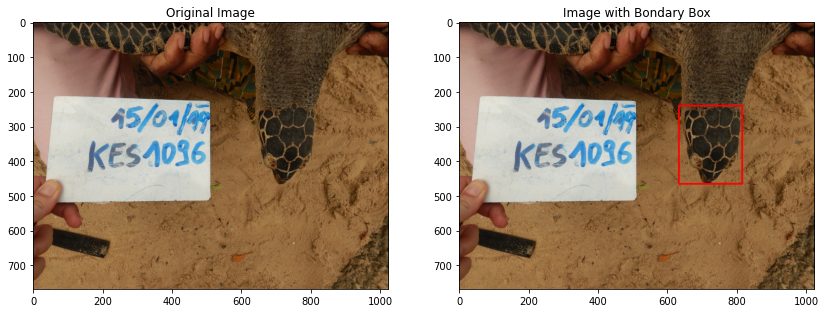

In [12]:
plot_img("B04E481E.jpg",image_df)

In [13]:
classes = image_df["class"].unique()

In [14]:
_classes = np.insert(classes, 0, "background", axis=0)        # adding a background class for Faster R-CNN
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, '1': 1}

int_to_class : 
 {0: 'background', 1: '1'}


In [15]:
class TortoiseDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, mode = 'train', transforms = None):
        
        super().__init__()
        
        self.image_names = dataframe["filename"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        
    def __getitem__(self, index: int):
        
        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df["filename"] == image_name]
#         print(self.image_dir +'\\'+ image_name)
        
        image = cv2.imread(self.image_dir +'\\'+ image_name+'.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.mode == 'train':
            
            #Get bounding box co-ordinates for each box
            boxes = records[['x', 'y', 'w', 'h']].values

            #Getting labels for each box
            temp_labels = records[['class']].values
            labels = []
            for label in temp_labels:
                label = class_to_int[label[0]]
                labels.append(label)

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name
        
        elif self.mode == 'test':

            if self.transforms:
                image = self.transforms(image)

            return image, image_name
    
    def __len__(self):
        return len(self.image_names)

In [16]:
def get_transform():
    return T.Compose([T.ToTensor()])

In [17]:
df=image_df.copy()

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))


#Dataset object
dataset = TortoiseDataset(df, DIR_IMAGES, transforms = get_transform())


# split the dataset in train and test set - using 80% for training, 20% for validation
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:650])
valid_dataset = torch.utils.data.Subset(dataset, indices[650:])




In [19]:
len(train_dataset.indices)

650

In [20]:
#Preparing data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 2,
    shuffle = True,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 2,
    shuffle = True,
    collate_fn = collate_fn
)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [12]:
device

device(type='cuda')

In [23]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [24]:
params = [p for p in model.parameters() if p.requires_grad]

#Defininig Optimizer
optimizer = torch.optim.Adam(params, lr = 0.001)
# optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9)

#LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Load pre-trained model
checkpoint = torch.load("fasterrcnn_resnet50_fpn_coco-258fb6c6.pth")
model.to(device)



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [25]:
#No of epochs
epochs = 10

In [30]:
itr = 1
total_train_loss = []

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss = []
    
    #Retriving Mini-batch
    for images, targets, image_names in train_data_loader:
        
        #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        #Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        #Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)
        
        if itr % 25 == 0:
            print(f"\n Iteration #{itr} loss: {out} \n")

        itr += 1
    
    #lr_scheduler.step()    
    
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)
    
    torch.save({
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'model': model
            }, "checkpoint_0.pth")


 Iteration #25 loss: {'loss_classifier': tensor(0.0692, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.1260, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #50 loss: {'loss_classifier': tensor(0.0794, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0728, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(4.7434e-06, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #75 loss: {'loss_classifier': tensor(0.0346, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0628, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_


 Iteration #600 loss: {'loss_classifier': tensor(0.0152, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0217, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(5.3532e-06, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #625 loss: {'loss_classifier': tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0138, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.3171e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #650 loss: {'loss_classifier': tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0270, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.9823e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWit


 Iteration #1175 loss: {'loss_classifier': tensor(0.0051, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.2107e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #1200 loss: {'loss_classifier': tensor(0.0107, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0124, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(9.6305e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #1225 loss: {'loss_classifier': tensor(0.0142, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0161, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(3.8837e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropy


 Iteration #1750 loss: {'loss_classifier': tensor(0.0057, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0208, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.7455e-06, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #1775 loss: {'loss_classifier': tensor(0.0069, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.8411e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #1800 loss: {'loss_classifier': tensor(0.0111, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0099, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.9546e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropy


 Iteration #2325 loss: {'loss_classifier': tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0126, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(5.6422e-05, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #2350 loss: {'loss_classifier': tensor(0.0101, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.5740e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(8.7887e-05, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #2375 loss: {'loss_classifier': tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0131, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(5.9130e-06, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWit


 Iteration #2900 loss: {'loss_classifier': tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(8.3595e-05, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #2925 loss: {'loss_classifier': tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)} 

Epoch train loss is 0.0145
Time elapsed:  202.795578956604

 Iteration #2950 loss: {'loss_classifier': tensor(0.0092, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0

Testing the model

In [2]:
from PIL import Image
from torchvision.transforms import ToTensor

In [9]:
def plot_img_pred(image_name):
    #Open and predict the bounding box
    img=image_name
    # image = Image.open(img)
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    image = ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
    image=image.to(device)
    out = model_new(image)
    output=np.array((out[0]['scores']>0.95).cpu())
    output=list(np.where(output==True)[0])
    boundingbox=out[0]['boxes'].cpu().detach().numpy()[output].tolist()
    
    #Draw bounding box on the image
    fig, ax = plt.subplots(1, figsize = (14, 14))
    img_path = os.path.join(image_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image   
    for row in boundingbox:
        x1 = row[0]
        y1 = row[1]
        x2 = row[2]
        y2 = row[3]
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
    ax.imshow(image2)
    plt.show()

In [4]:
model_new = torch.load('checkpoint_0.pth')

In [5]:
model_new=model_new['model']
model_new=model_new.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


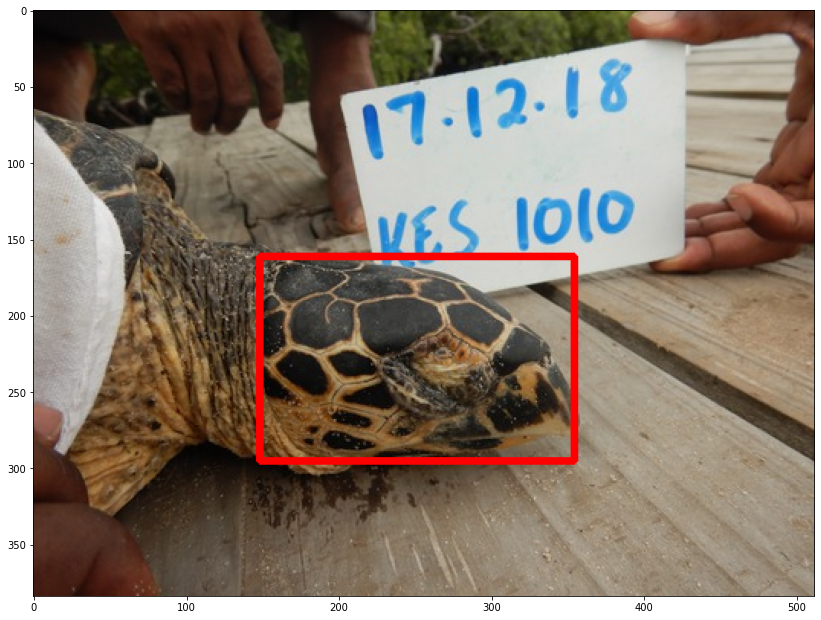

In [13]:
plot_img_pred('images/0B4BD7E5.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


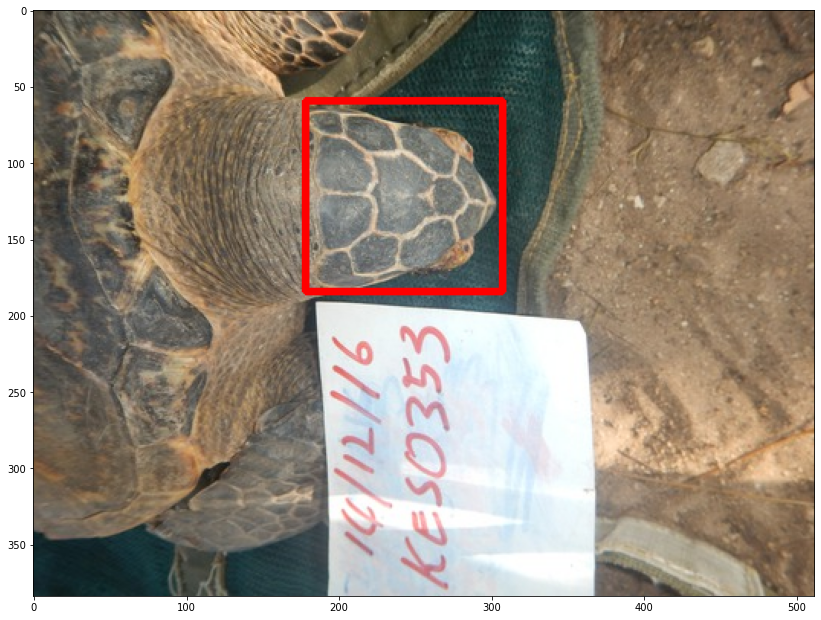

In [15]:
plot_img_pred('images/2DF693B3.jpg')